# 🧪 Tutorial: Train Your Own Tiny Diffusion Model (2D)

**Topic:** Denoising Diffusion Probabilistic Models (DDPM)  
**Time:** ~30–45 minutes  
**Based on:** Ho, Jain & Abbeel (2020), *"Denoising Diffusion Probabilistic Models"*, NeurIPS 2020  
**Slides:** [Presentation by Mengyan Jing](https://constantine-jing.github.io/Probabilistic-Denoising-Diffusion-Models/)  

---

## What you'll do

In this tutorial you will **train a small diffusion model from scratch** on a simple 2D dataset (Swiss Roll). No GPUs needed — everything runs on a laptop CPU in a few minutes.

By the end you will:
1. Understand the **forward process** (adding noise)
2. Implement the **noise schedule** and the closed-form shortcut $q(x_t | x_0)$
3. Build and train a **small neural network** that predicts noise ($\varepsilon$-prediction)
4. **Sample** new points by running the reverse process
5. **Visualize** how structure emerges from noise

---
## Part 0: Setup

Run the cell below to import everything we need. Standard libraries only — no special diffusion packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll

torch.manual_seed(42)
np.random.seed(42)
device = "cpu"  # this tutorial is designed to run on CPU
print("Setup complete! Using device:", device)

Setup complete! Using device: cpu


---
## Part 1: Create the Dataset

We'll use the **Swiss Roll** — a classic 2D dataset that has interesting curved structure. Our diffusion model will learn to generate new Swiss Roll points from pure noise.

Think of each point as a tiny "image" with just 2 pixels.

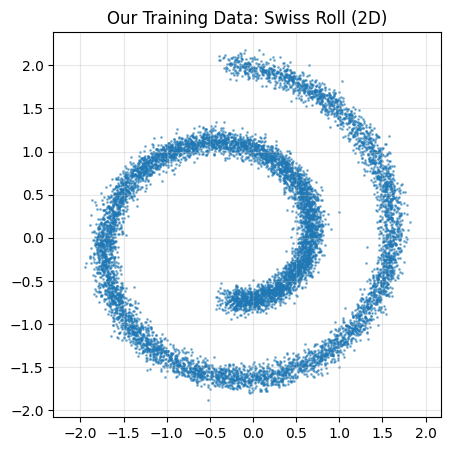

Dataset shape: torch.Size([10000, 2])  (10000 points, 2 dimensions)


In [2]:
# Generate Swiss Roll data (2D only)
data, _ = make_swiss_roll(n_samples=10000, noise=0.5)
data = data[:, [0, 2]]  # keep only x and z (the 2D spiral)

# Normalize to roughly [-1, 1]
data = (data - data.mean(axis=0)) / data.std(axis=0)
dataset = torch.tensor(data, dtype=torch.float32)

plt.figure(figsize=(5, 5))
plt.scatter(dataset[:, 0], dataset[:, 1], s=1, alpha=0.5)
plt.title("Our Training Data: Swiss Roll (2D)")
plt.axis("equal")
plt.grid(alpha=0.3)
plt.show()
print(f"Dataset shape: {dataset.shape}  (10000 points, 2 dimensions)")

---
## Part 2: The Forward Process (Adding Noise)

The key idea of DDPM: **slowly destroy data by adding Gaussian noise**.

At each timestep $t$, we add a bit of noise controlled by a **schedule** $\beta_t$:

$$q(x_t | x_{t-1}) = \mathcal{N}(x_t;\; \sqrt{1-\beta_t}\, x_{t-1},\; \beta_t I)$$

But here's the shortcut — we can jump directly to any timestep $t$ from the clean data $x_0$:

$$x_t = \sqrt{\bar{\alpha}_t}\; x_0 + \sqrt{1 - \bar{\alpha}_t}\; \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, I)$$

where $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$.

Let's implement this!

In [3]:
# ── Define the noise schedule ──
T = 300            # number of diffusion steps (small for speed)
beta_start = 1e-4
beta_end = 0.02

# Linear schedule (Ho et al. 2020)
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1.0 - betas
alpha_bar = torch.cumprod(alphas, dim=0)  # cumulative product

print(f"beta range: [{betas[0]:.4f}, {betas[-1]:.4f}]")
print(f"alpha_bar at t=0:   {alpha_bar[0]:.4f}  (mostly signal)")
print(f"alpha_bar at t=T-1: {alpha_bar[-1]:.4f}  (mostly noise)")

beta range: [0.0001, 0.0200]
alpha_bar at t=0:   0.9999  (mostly signal)
alpha_bar at t=T-1: 0.0481  (mostly noise)


In [4]:
def q_sample(x0, t, alpha_bar):
    """
    Forward process: sample x_t given x_0 using the closed-form shortcut.
    
    x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * eps
    """
    noise = torch.randn_like(x0)
    sqrt_ab = torch.sqrt(alpha_bar[t]).unsqueeze(-1)      # signal scaling
    sqrt_one_minus_ab = torch.sqrt(1 - alpha_bar[t]).unsqueeze(-1)  # noise scaling
    x_t = sqrt_ab * x0 + sqrt_one_minus_ab * noise
    return x_t, noise

### Visualize: Watch the data get destroyed

Let's see what happens to our Swiss Roll as we increase $t$.

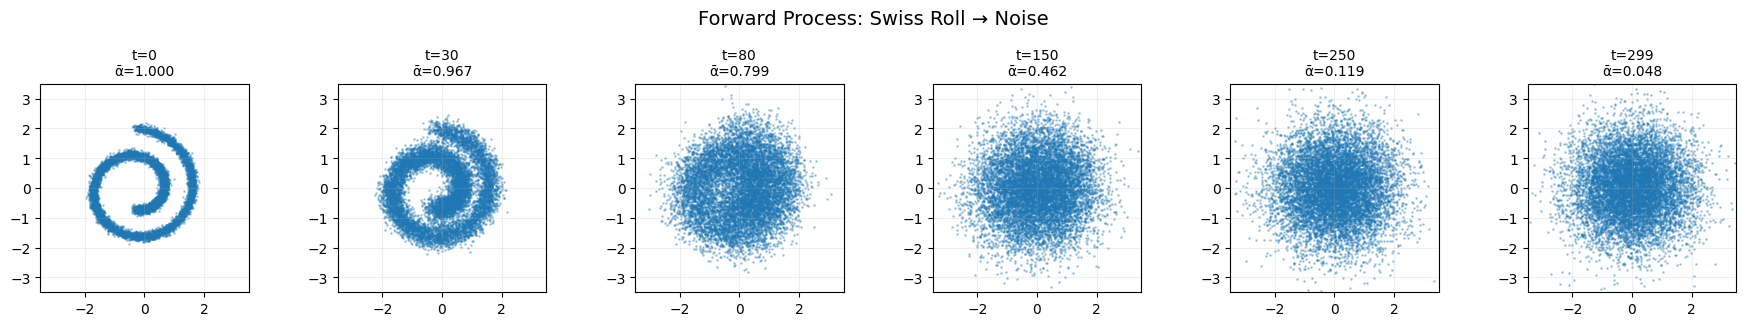

In [5]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
timesteps_to_show = [0, 30, 80, 150, 250, 299]

for ax, t_val in zip(axes, timesteps_to_show):
    t_tensor = torch.full((dataset.shape[0],), t_val, dtype=torch.long)
    x_t, _ = q_sample(dataset, t_tensor, alpha_bar)
    ax.scatter(x_t[:, 0].numpy(), x_t[:, 1].numpy(), s=1, alpha=0.3)
    ab = alpha_bar[t_val].item()
    ax.set_title(f"t={t_val}\nᾱ={ab:.3f}", fontsize=10)
    ax.set_xlim(-3.5, 3.5); ax.set_ylim(-3.5, 3.5)
    ax.set_aspect("equal"); ax.grid(alpha=0.2)

fig.suptitle("Forward Process: Swiss Roll → Noise", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## Part 3: Build the Denoising Network

The neural network takes in a **noisy point** $x_t$ and the **timestep** $t$, and predicts the **noise** $\varepsilon$ that was added.

We use a simple MLP (multi-layer perceptron) since our data is just 2D. For images you'd use a U-Net, but the idea is identical.

**Timestep embedding:** We encode $t$ using sinusoidal embeddings (same idea as positional encoding in Transformers), so the network knows which noise level it's dealing with.

In [6]:
class SinusoidalEmbedding(nn.Module):
    """Encode timestep t into a vector using sin/cos (like Transformer positional encoding)."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-np.log(10000) * torch.arange(half, dtype=torch.float32) / half).to(t.device)
        args = t.float().unsqueeze(-1) * freqs.unsqueeze(0)
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)


class SimpleNoisePredictor(nn.Module):
    """
    A small MLP that predicts the noise epsilon given (x_t, t).
    
    Input:  x_t (batch, 2) + time_emb (batch, 64)
    Output: predicted noise (batch, 2)
    """
    def __init__(self, data_dim=2, hidden=128, time_dim=64):
        super().__init__()
        self.time_embed = SinusoidalEmbedding(time_dim)
        self.net = nn.Sequential(
            nn.Linear(data_dim + time_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, data_dim),
        )
    
    def forward(self, x_t, t):
        t_emb = self.time_embed(t)           # (batch, 64)
        inp = torch.cat([x_t, t_emb], dim=-1)  # (batch, 2+64)
        return self.net(inp)                  # (batch, 2) = predicted noise

model = SimpleNoisePredictor().to(device)
n_params = sum(p.numel() for p in model.parameters())
print(f"Model has {n_params:,} parameters — tiny!")

Model has 41,858 parameters — tiny!


---
## Part 4: Train the Model

The training loop is remarkably simple (this is the beauty of DDPM):

1. Sample a clean data point $x_0$
2. Pick a random timestep $t$
3. Add noise to get $x_t$ (using our shortcut formula)
4. Ask the network to predict the noise
5. Loss = MSE between real noise and predicted noise

$$\mathcal{L}_{\text{simple}} = \mathbb{E}_{t, x_0, \varepsilon}\left[\|\varepsilon - \varepsilon_\theta(x_t, t)\|^2\right]$$

That's it!

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 256
n_epochs = 80
losses = []

print("Training...")
for epoch in range(n_epochs):
    # Shuffle data
    perm = torch.randperm(dataset.shape[0])
    epoch_loss = 0.0
    n_batches = 0
    
    for i in range(0, dataset.shape[0], batch_size):
        x0 = dataset[perm[i:i+batch_size]].to(device)
        batch_len = x0.shape[0]
        
        # Step 1: Pick random timesteps
        t = torch.randint(0, T, (batch_len,), device=device)
        
        # Step 2: Add noise (forward process shortcut)
        x_t, noise = q_sample(x0, t, alpha_bar)
        
        # Step 3: Predict the noise
        noise_pred = model(x_t, t)
        
        # Step 4: MSE loss
        loss = nn.functional.mse_loss(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    losses.append(avg_loss)
    if (epoch + 1) % 20 == 0:
        print(f"  Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

print("Done!")

Training...
  Epoch 20/80, Loss: 0.4805
  Epoch 40/80, Loss: 0.4618
  Epoch 60/80, Loss: 0.4732
  Epoch 80/80, Loss: 0.4689
Done!


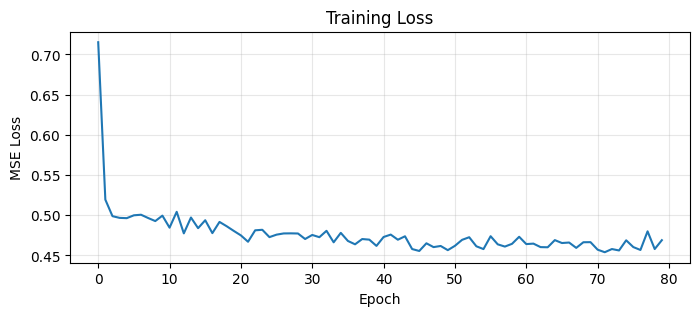

In [8]:
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.title("Training Loss"); plt.grid(alpha=0.3)
plt.show()

---
## Part 5: Sample New Data (The Reverse Process!)

Now the exciting part — **generate new Swiss Roll points from pure noise**.

The sampling algorithm (from the slides):

```
1. Sample x_T ~ N(0, I)                       ← start from pure noise
2. For t = T-1, T-2, ..., 0:
     predicted_noise = model(x_t, t)
     Use predicted_noise to compute x_{t-1}    ← one denoising step
3. Return x_0                                  ← your generated sample!
```

The exact update formula is:

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\,\varepsilon_\theta(x_t,t)\right) + \sigma_t z$$

where $z \sim \mathcal{N}(0,I)$ and $\sigma_t = \sqrt{\beta_t}$.

In [9]:
@torch.no_grad()
def sample_ddpm(model, n_samples, T, betas, alphas, alpha_bar):
    """Generate new samples by running the reverse process."""
    # Start from pure noise
    x = torch.randn(n_samples, 2).to(device)
    
    trajectory = [x.clone()]  # save trajectory for visualization
    
    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, dtype=torch.long, device=device)
        
        # Predict noise
        eps_pred = model(x, t_batch)
        
        # Compute x_{t-1}
        coeff1 = 1.0 / torch.sqrt(alphas[t])
        coeff2 = betas[t] / torch.sqrt(1.0 - alpha_bar[t])
        
        x = coeff1 * (x - coeff2 * eps_pred)
        
        # Add noise (except at the final step)
        if t > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(betas[t])
            x = x + sigma * noise
        
        if t % 50 == 0:
            trajectory.append(x.clone())
    
    trajectory.append(x.clone())
    return x, trajectory

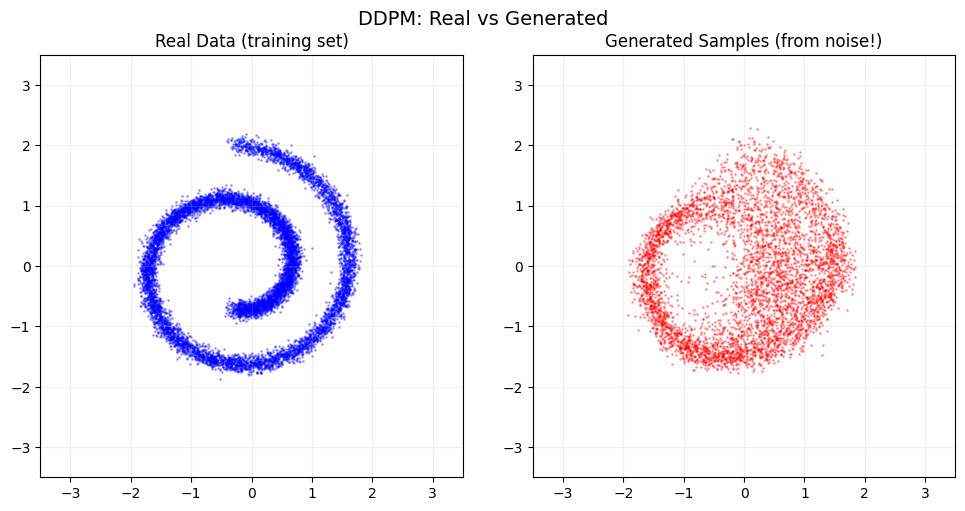

In [10]:
# Generate 5000 new points!
samples, trajectory = sample_ddpm(model, 5000, T, betas, alphas, alpha_bar)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(dataset[:, 0], dataset[:, 1], s=1, alpha=0.3, c="blue")
axes[0].set_title("Real Data (training set)")
axes[0].set_xlim(-3.5, 3.5); axes[0].set_ylim(-3.5, 3.5)
axes[0].set_aspect("equal"); axes[0].grid(alpha=0.2)

axes[1].scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), s=1, alpha=0.3, c="red")
axes[1].set_title("Generated Samples (from noise!)")
axes[1].set_xlim(-3.5, 3.5); axes[1].set_ylim(-3.5, 3.5)
axes[1].set_aspect("equal"); axes[1].grid(alpha=0.2)

plt.suptitle("DDPM: Real vs Generated", fontsize=14)
plt.tight_layout()
plt.show()

---
## Part 6: Visualize the Reverse Process

Let's watch structure emerge from noise step by step — this is the "magic" of diffusion models!

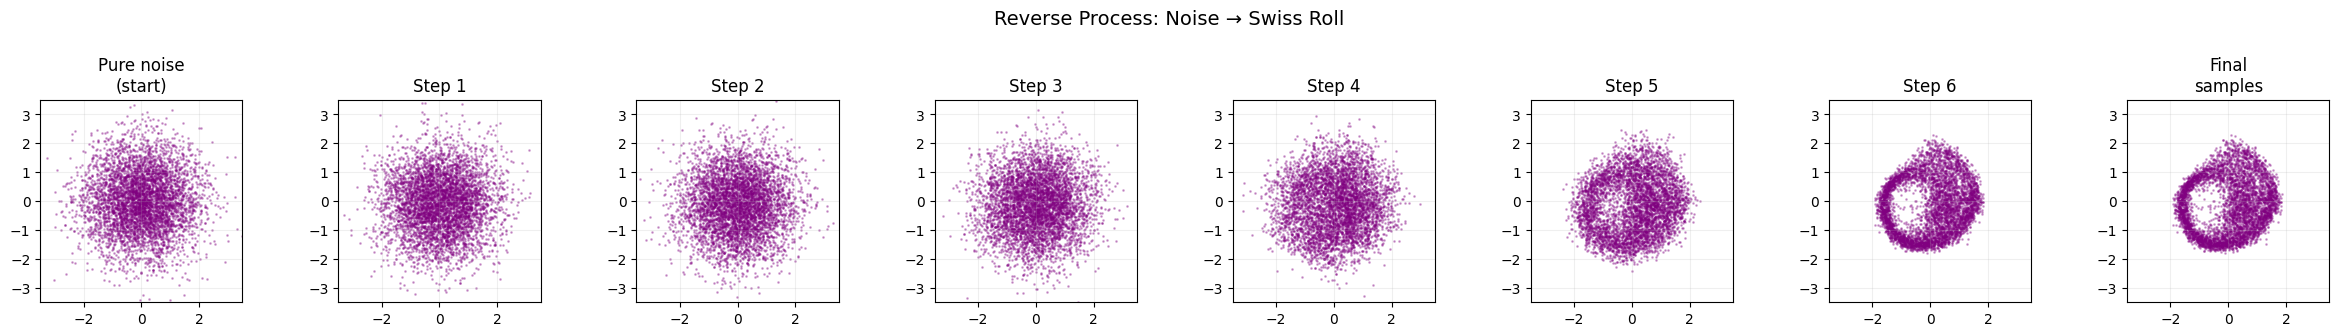

In [11]:
fig, axes = plt.subplots(1, len(trajectory), figsize=(3 * len(trajectory), 3))
for i, (ax, snap) in enumerate(zip(axes, trajectory)):
    ax.scatter(snap[:, 0].numpy(), snap[:, 1].numpy(), s=1, alpha=0.3, c="purple")
    ax.set_xlim(-3.5, 3.5); ax.set_ylim(-3.5, 3.5)
    ax.set_aspect("equal"); ax.grid(alpha=0.2)
    if i == 0:
        ax.set_title("Pure noise\n(start)")
    elif i == len(trajectory) - 1:
        ax.set_title("Final\nsamples")
    else:
        ax.set_title(f"Step {i}")

fig.suptitle("Reverse Process: Noise → Swiss Roll", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

---
## Part 7 (Bonus): Compare Linear vs Cosine Schedule

Nichol & Dhariwal (2021) proposed a **cosine schedule** that destroys information more gradually. Let's compare!

$$\bar{\alpha}_t = \frac{f(t)}{f(0)}, \quad f(t) = \cos\left(\frac{t/T + s}{1+s} \cdot \frac{\pi}{2}\right)^2$$

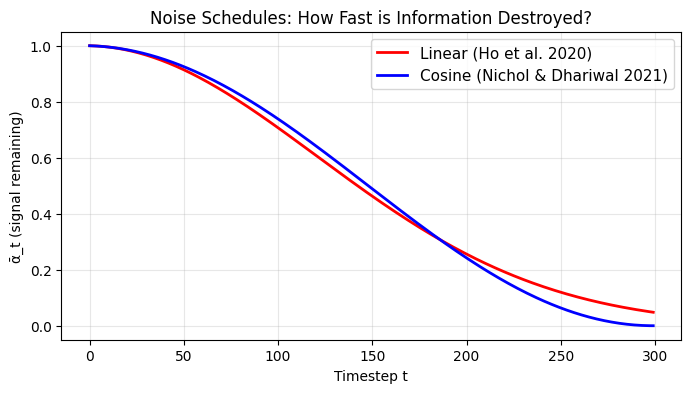

Notice: The linear schedule destroys most signal by t≈200,
while cosine preserves useful signal across ALL timesteps.


In [12]:
# Cosine schedule (Nichol & Dhariwal 2021)
s = 0.008
steps = torch.arange(T + 1, dtype=torch.float64)
f = torch.cos(((steps / T) + s) / (1 + s) * torch.pi / 2) ** 2
alpha_bar_cosine = (f / f[0])[1:]

plt.figure(figsize=(8, 4))
plt.plot(alpha_bar.numpy(), label="Linear (Ho et al. 2020)", linewidth=2, color="red")
plt.plot(alpha_bar_cosine.numpy(), label="Cosine (Nichol & Dhariwal 2021)", linewidth=2, color="blue")
plt.xlabel("Timestep t"); plt.ylabel("ᾱ_t (signal remaining)")
plt.title("Noise Schedules: How Fast is Information Destroyed?")
plt.legend(fontsize=11); plt.grid(alpha=0.3)
plt.show()
print("Notice: The linear schedule destroys most signal by t≈200,")
print("while cosine preserves useful signal across ALL timesteps.")

---
## Summary

| Concept | What we did |
|---|---|
| **Forward process** | Added noise to Swiss Roll using $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t}\varepsilon$ |
| **Model** | Small MLP with sinusoidal time embedding predicts $\varepsilon$ |
| **Training** | Simple MSE loss: $\|\varepsilon - \varepsilon_\theta(x_t, t)\|^2$ |
| **Sampling** | Reverse process: iteratively denoise from $x_T$ to $x_0$ |
| **Schedule** | Compared linear vs cosine noise schedules |

### Key takeaways
- DDPM decomposes one hard generative problem into many easy denoising steps
- Training is just "predict the noise" — beautifully simple
- The same ideas scale to images (U-Net), audio, protein structures, etc.
- The main downside: sampling requires many steps (addressed by Consistency Models — see slides!)

### References
- Ho, Jain & Abbeel (2020). *Denoising Diffusion Probabilistic Models.* NeurIPS.
- Nichol & Dhariwal (2021). *Improved Denoising Diffusion Probabilistic Models.* ICML.
- Song et al. (2023). *Consistency Models.* ICML.